## 

## Plan: 
1.) apply naive ML techniques to the csv data, try to gain insights.

In [1]:
import os
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression as sk_OLS
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import math

from sklearn.metrics import r2_score
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

In [2]:

cross_sectional = pd.read_csv("datacsv/oasis_cross-sectional.csv")
cross_sectional.fillna(value=0, inplace=True)
y = cross_sectional.CDR
X = cross_sectional.drop(["CDR", "M/F", "Hand", "ID"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train))
print(len(y_train))
print(len(X_test))
# print(X_test)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
    


327
327
109


In [3]:
def rename(x):
    if x == "Nondemented":
        return 0.0
    elif x == "Demented" or x == "Converted":
        return 1.0
    else:
        return x

In [15]:
longitudinal = pd.read_csv("datacsv/oasis_longitudinal.csv")
cross_sectional = pd.read_csv("datacsv/oasis_cross-sectional.csv")

frames = [cross_sectional, longitudinal]
combined = pd.concat(frames)
# combined = combined.rename(columns={"Group": "CDR"})
combined = combined.map(rename)
# combined["Group"] = combined["Group"].astype('float')
# print(combined)
combined.reset_index(inplace=True, drop=True)

# TODO: dont fillNA pull out CDR that are NA and use those as testing set. 
# combined.fillna(value=0, inplace=True)

# print(combined)
combined.to_csv("combined.csv")

                ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
3    OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  NaN  1588  0.803  1.105   
4    OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  NaN  1737  0.848  1.010   
5    OAS1_0006_MR1   F    R   24   NaN  NaN   NaN  NaN  1131  0.862  1.551   
6    OAS1_0007_MR1   M    R   21   NaN  NaN   NaN  NaN  1516  0.830  1.157   
7    OAS1_0009_MR1   F    R   20   NaN  NaN   NaN  NaN  1505  0.843  1.166   
..             ...  ..  ...  ...   ...  ...   ...  ...   ...    ...    ...   
431  OAS1_0285_MR2   M    R   20   NaN  NaN   NaN  NaN  1469  0.847  1.195   
432  OAS1_0353_MR2   M    R   22   NaN  NaN   NaN  NaN  1684  0.790  1.042   
433  OAS1_0368_MR2   M    R   22   NaN  NaN   NaN  NaN  1580  0.856  1.111   
434  OAS1_0379_MR2   F    R   20   NaN  NaN   NaN  NaN  1262  0.861  1.390   
435  OAS1_0395_MR2   F    R   26   NaN  NaN   NaN  NaN  1283  0.834  1.368   

     Delay Subject ID MRI ID  Group  Visit  MR Delay  EDUC  
3 

In [22]:
cdr_na = combined["CDR"].isna()
# print(combined[cdr_na])

test = combined[cdr_na]
train = combined[~cdr_na]

print(len(train)/len(combined))

y_train = train.CDR
X_train = train.drop(["CDR", "M/F", "Hand", "Subject ID", "MRI ID", "ID", "Group", "Visit", "Educ", "EDUC", "Delay"], axis=1)

x_test = test.drop(["CDR", "M/F", "Hand", "Subject ID", "MRI ID", "ID", "Group", "Visit", "Educ", "EDUC", "Delay", "MR Delay", "SES", "MMSE"], axis=1)
print(x_test)
## it looks like the x_test is also missing: "MR Delay", "SES", "MMSE"

0.7515451174289246
     Age  eTIV   nWBV    ASF
3     28  1588  0.803  1.105
4     18  1737  0.848  1.010
5     24  1131  0.862  1.551
6     21  1516  0.830  1.157
7     20  1505  0.843  1.166
..   ...   ...    ...    ...
431   20  1469  0.847  1.195
432   22  1684  0.790  1.042
433   22  1580  0.856  1.111
434   20  1262  0.861  1.390
435   26  1283  0.834  1.368

[201 rows x 4 columns]


[9.95979973e-01 4.01995587e-03 5.64445013e-08 1.47082818e-08]
[2.16501342e+03 1.37545356e+02 5.15402011e-01 2.63097220e-01]


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


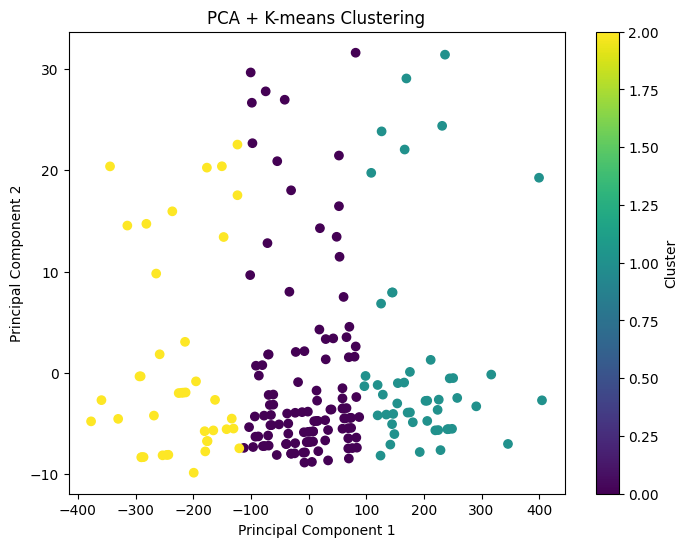

In [28]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=4)
componenets = pca.fit_transform(x_test)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
# print(componenets)

kmeans = KMeans(n_clusters=3)  # Set the number of clusters
kmeans.fit(componenets)
cluster_labels = kmeans.labels_

# Visualize the clusters in 2D
plt.figure(figsize=(8, 6))
plt.scatter(componenets[:, 0], componenets[:, 1], c=cluster_labels, cmap='viridis')
plt.title('PCA + K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [5]:

# y = combined.CDR
# combined["NewEd"] = combined.Educ + combined.EDUC
# X = combined.drop(["CDR", "M/F", "Hand", "Subject ID", "MRI ID", "ID", "Group", "Visit", "Educ", "EDUC", "Delay"], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
print(len(X_train))
# print(y_train)
print(len(X_test))
print(X)
# print(X_test)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

606
203
     Age  SES  MMSE  eTIV   nWBV    ASF  MR Delay  NewEd
0     74  3.0  29.0  1344  0.743  1.306       0.0    2.0
1     55  1.0  29.0  1147  0.810  1.531       0.0    4.0
2     73  3.0  27.0  1454  0.708  1.207       0.0    4.0
3     28  0.0   0.0  1588  0.803  1.105       0.0    0.0
4     18  0.0   0.0  1737  0.848  1.010       0.0    0.0
..   ...  ...   ...   ...    ...    ...       ...    ...
804   82  1.0  28.0  1693  0.694  1.037     842.0   16.0
805   86  1.0  26.0  1688  0.675  1.040    2297.0   16.0
806   61  2.0  30.0  1319  0.801  1.331       0.0   13.0
807   63  2.0  30.0  1327  0.796  1.323     763.0   13.0
808   65  2.0  30.0  1333  0.801  1.317    1608.0   13.0

[809 rows x 8 columns]


In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB(alpha=1e-3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

print(clf.feature_count_)

Accuracy:  0.06403940886699508
[[3.42620e+04 9.59000e+02 1.13250e+04 8.17676e+05 4.24241e+02 6.62555e+02
  1.58023e+05 4.17000e+03]
 [3.85200e+03 1.08000e+02 1.05000e+03 7.76030e+04 3.57910e+01 5.94290e+01
  1.43470e+04 4.94000e+02]
 [2.35000e+02 7.00000e+00 5.50000e+01 4.51200e+03 2.16300e+00 3.53200e+00
  1.17500e+03 3.70000e+01]]


In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
clf_sgd.fit(X_train, y_train)
y_pred = clf_sgd.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

# why are there three of these 
print(f"Coef\n{clf_sgd.coef_}")

coefficients = clf_sgd.coef_
# Find the top weighted coefficients
top_coefficients = sorted(enumerate(coefficients[0]), key=lambda x: abs(x[1]), reverse=True)[:8]
coef_names = ["Age", "SES", "MMSE", "eTIV", "nWBV", "ASF", "MR Delay", "NewEd"]

print(top_coefficients)
ranked = []
for i in top_coefficients:
    print(coef_names[i[0]])
    ranked.append(coef_names[i[0]])

Accuracy:  0.9014778325123153
Coef
[[-4.47540701e+04 -7.40676827e+02  2.01550046e+04  5.30860524e+03
   6.04963598e+02  6.70474314e+02  2.42173515e+03 -9.94731506e+03]
 [ 4.52594092e+04  1.33648906e+03 -1.46702327e+04 -2.91365942e+03
  -5.62486339e+02 -6.01043482e+02 -9.99535251e+02  8.45499224e+03]
 [ 4.35308411e+03  8.18761902e+01 -1.36460317e+03 -9.41576187e+02
  -1.30365089e+01 -2.41079893e+00 -1.19630211e+03  1.27817830e+03]]
[(0, -44754.07010706646), (2, 20155.004573183516), (7, -9947.315062771546), (3, 5308.605243156409), (6, 2421.7351537827417), (1, -740.6768267832572), (5, 670.474314303389), (4, 604.9635976955839)]
Age
MMSE
NewEd
eTIV
MR Delay
SES
ASF
nWBV


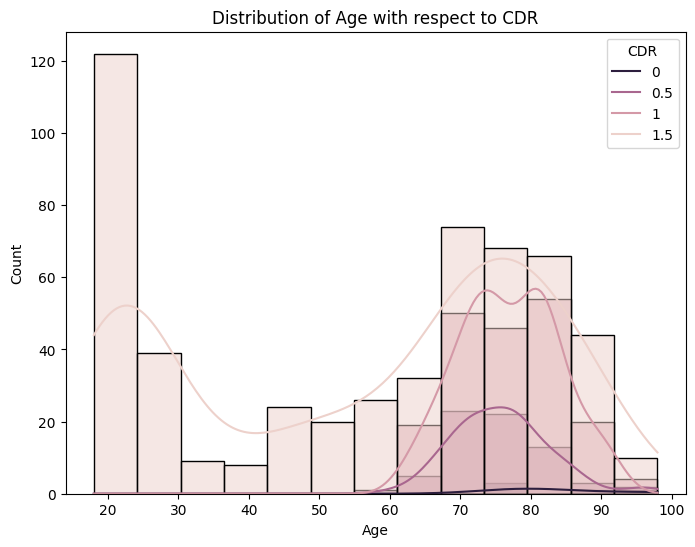

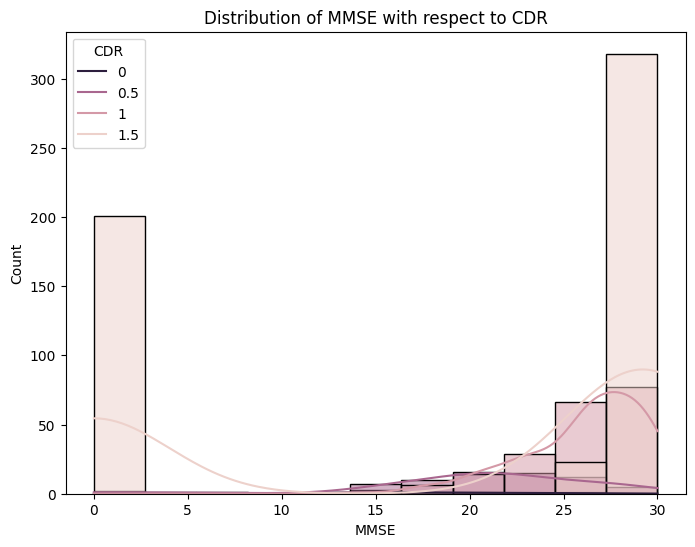

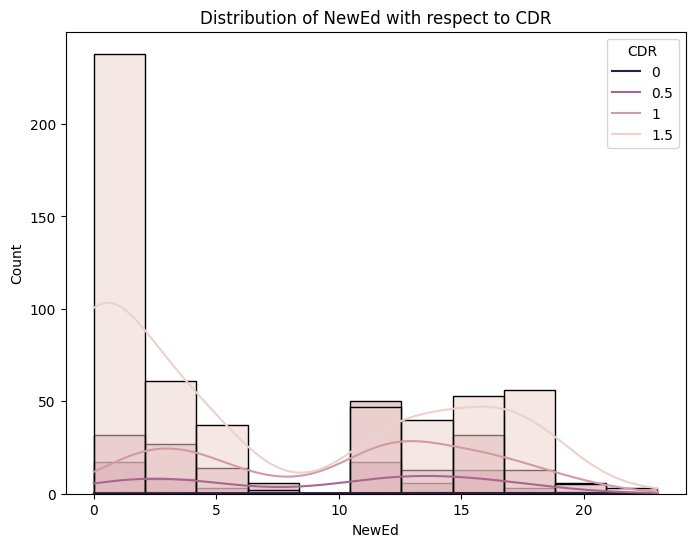

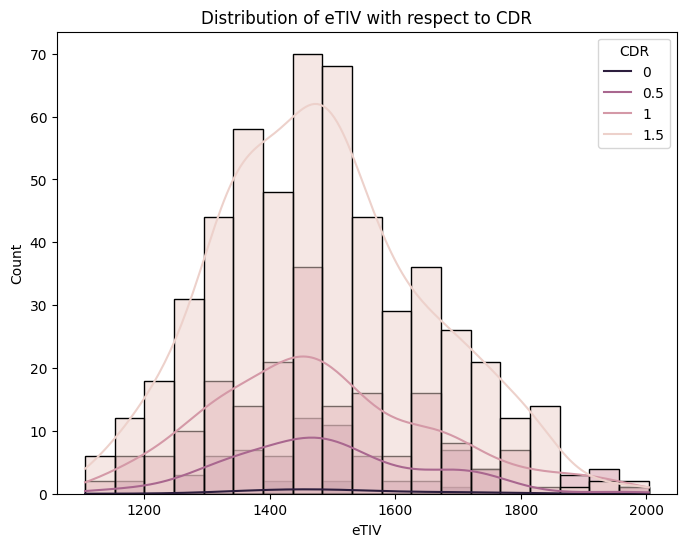

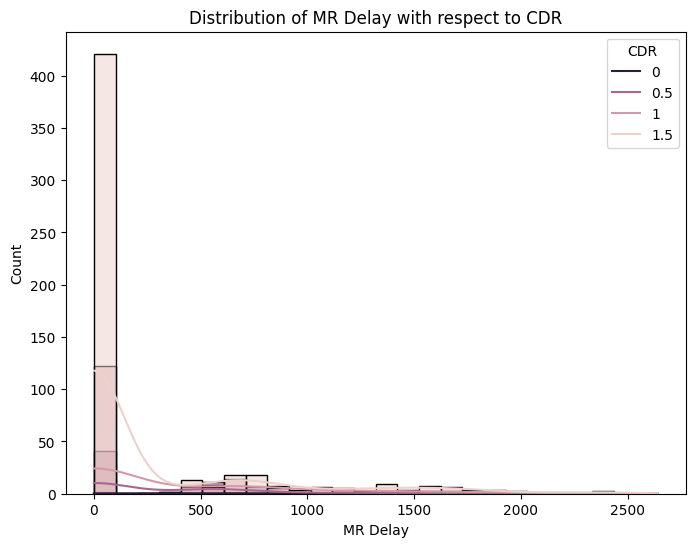

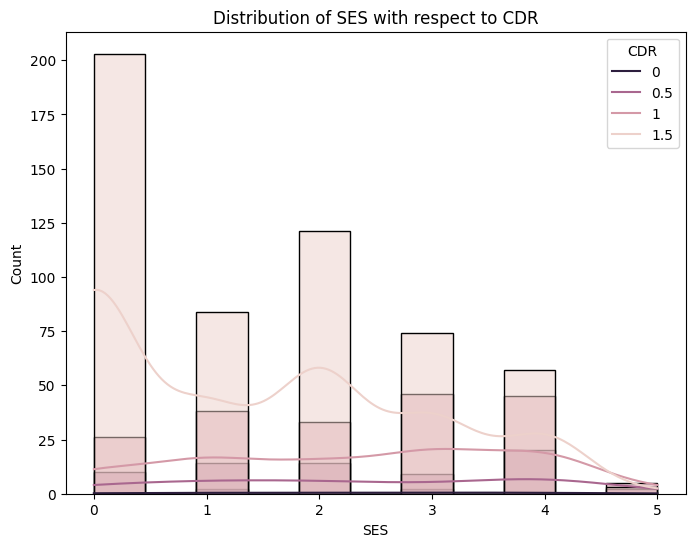

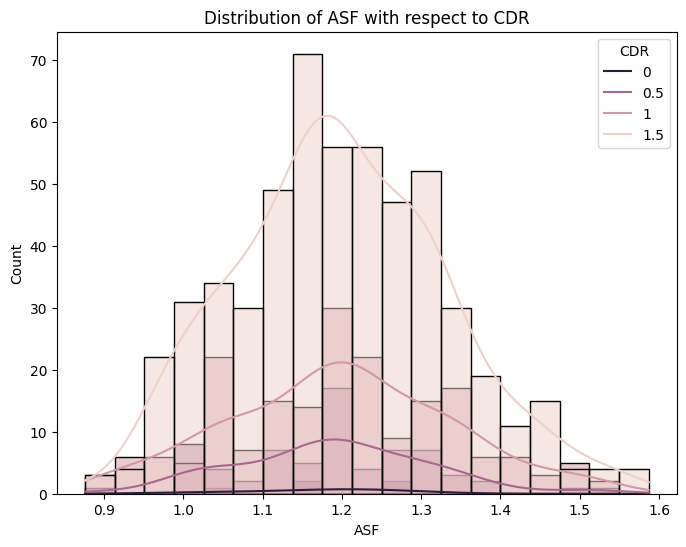

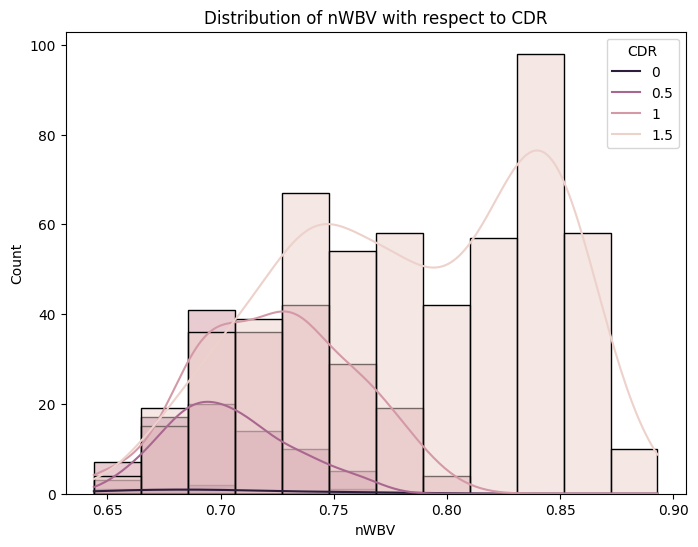

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'feature1', 'feature2', etc., with the actual feature column names in your dataset
# Replace 'class_label' with the actual class label column name in your dataset
features = ['feature1', 'feature2', 'feature3']  # Add all your feature column names here
features = ranked
class_label = 'CDR'

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=combined, x=feature, hue=class_label, kde=True)
    plt.title(f"Distribution of {feature} with respect to {class_label}")
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend([0,.5,1,1.5], title=class_label)
    plt.show()


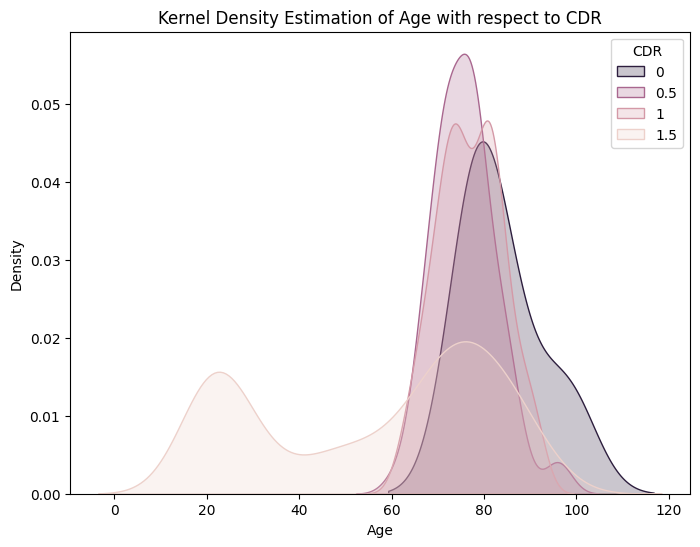

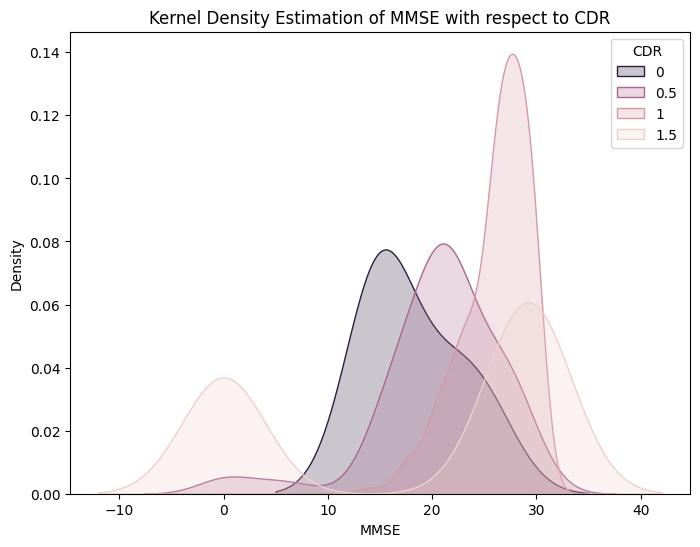

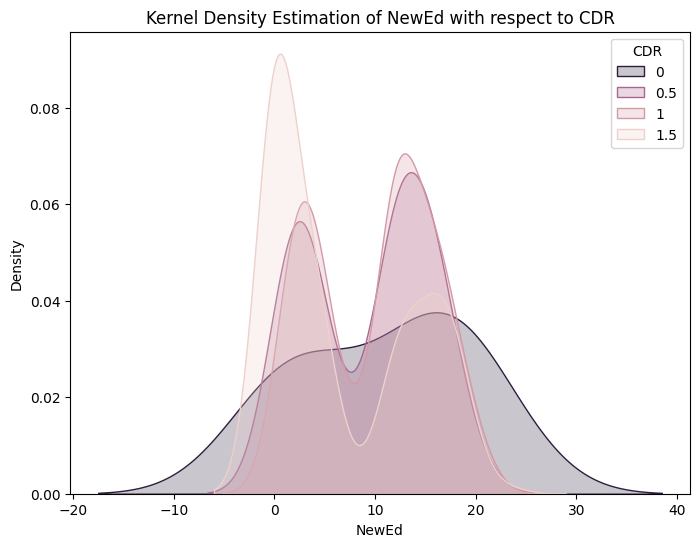

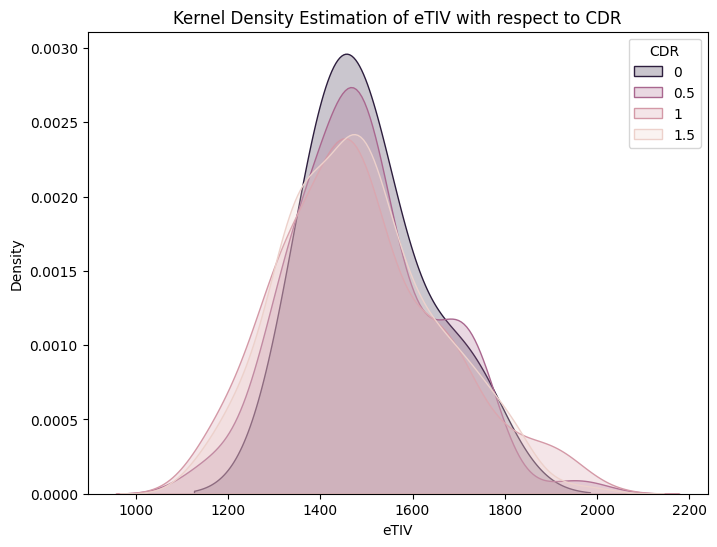

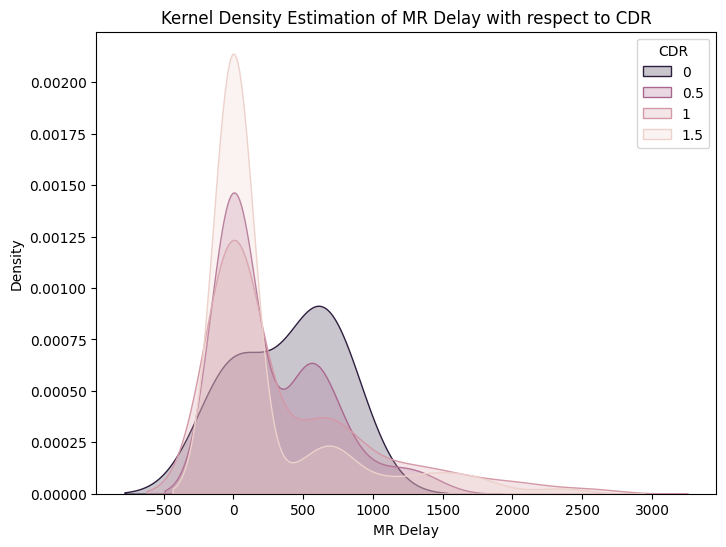

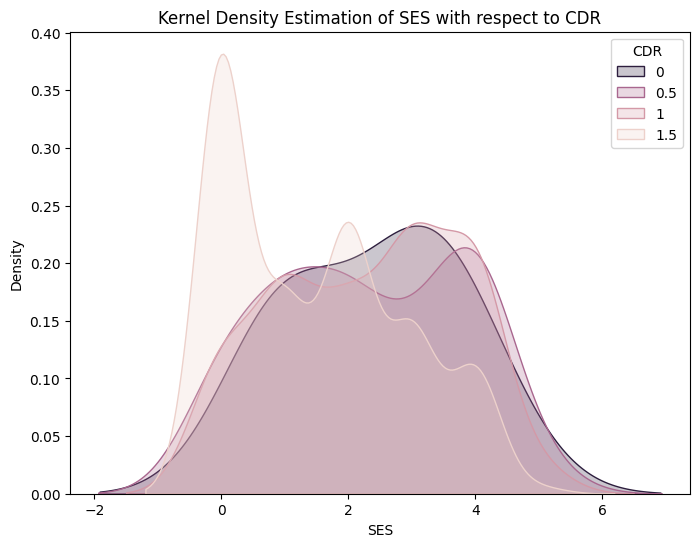

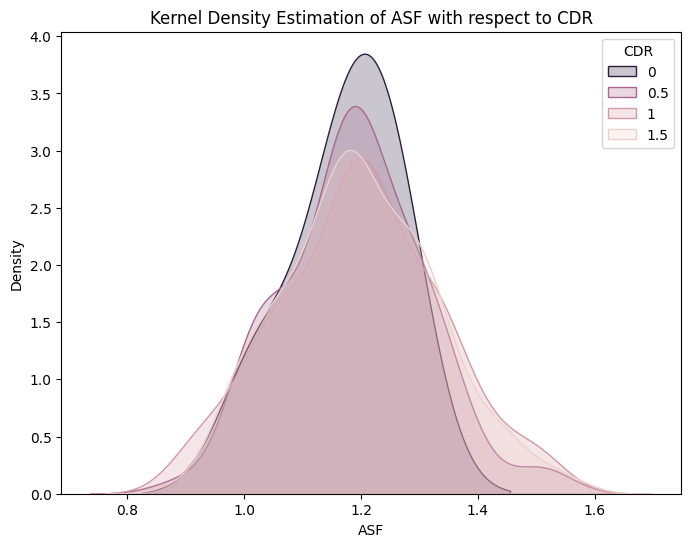

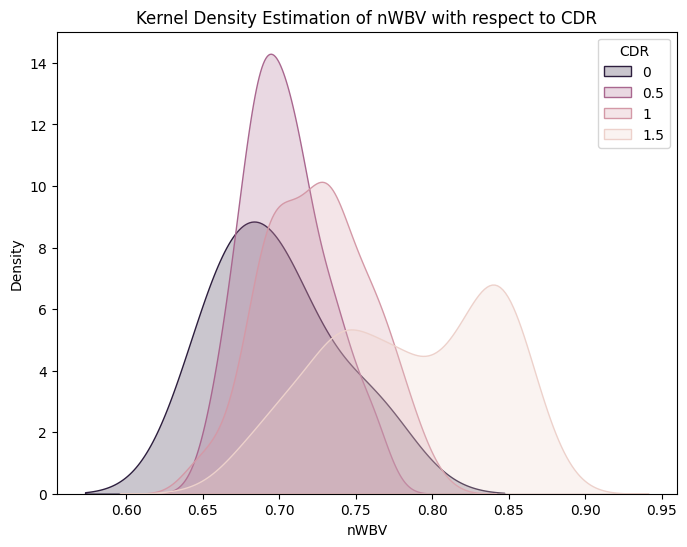

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ranked
class_label = 'CDR'

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=combined, x=feature, hue=class_label, fill=True, common_norm=False)
    plt.title(f"Kernel Density Estimation of {feature} with respect to {class_label}")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend([0,.5,1,1.5], title=class_label)
    plt.show()



## Analysis

